In [1]:
import pandas as pd 
import numpy as np 
from scipy.optimize import minimize 
df = pd.read_csv("ARP_Returns.csv")
for i,j in enumerate(list(df.columns[1:])):
    print(i+1,j)

1 Equity Momentum
2 Equity Low Beta
3 Equity Quality
4 Commodity Carry
5 Commodity Curve
6 Credit Curve
7 Credit Carry
8 FX Carry
9 FX Value
10 Interest Rate Spread
11 Interest Rate Curve
12 Equity Trend
13 FX Trend
14 Commodity Trend
15 Interest Rate Trend
16 Commodity Volatility Carry
17 Interest Rate Volatility Carry
18 Equity Volatility Carry
19 COT
20 Merger Arb


In [2]:
def cal_return(df):
    df_norm = pd.DataFrame()
    df_return = pd.DataFrame()
    df_return['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df_norm['Date'] = df_return['Date']
    strategy_list = list(df.columns[1:])
    for strategy in strategy_list:
        cleaned_name = strategy.lower().replace(' ', '_')
        df_norm[cleaned_name] = df[strategy]/df[strategy].iloc[0]
        df_return[cleaned_name] = df_norm[cleaned_name].diff()/df_norm[cleaned_name]
    return df_norm, df_return
df_norm, df_return = cal_return(df)

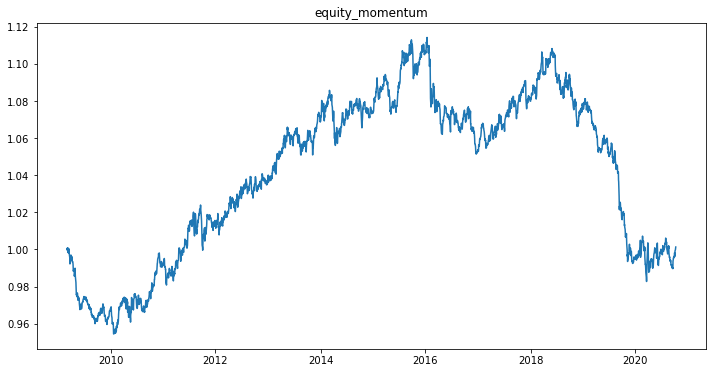

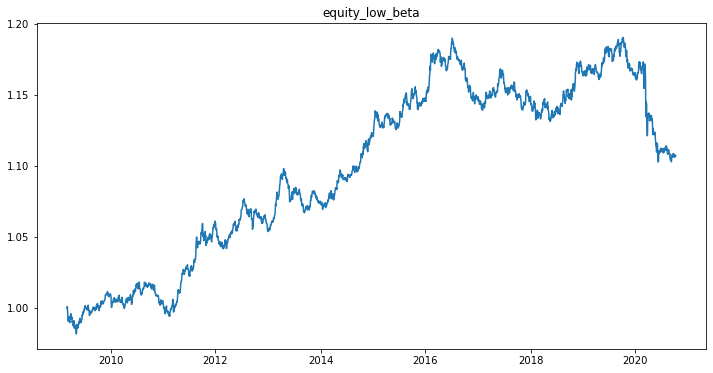

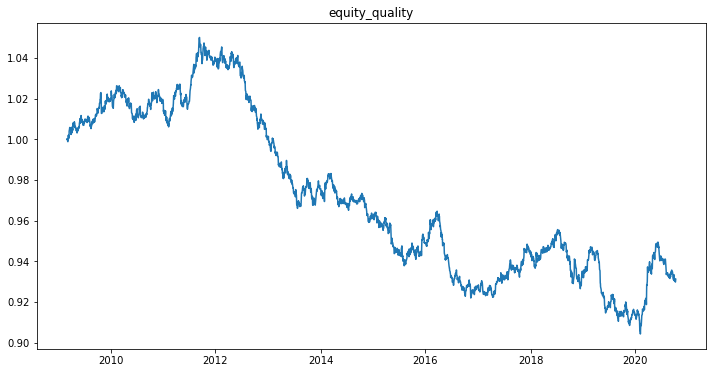

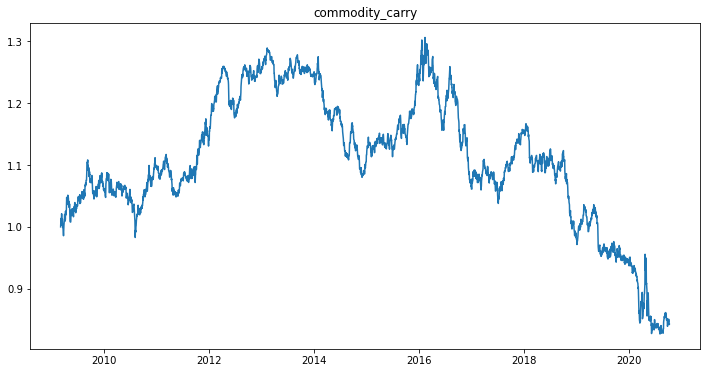

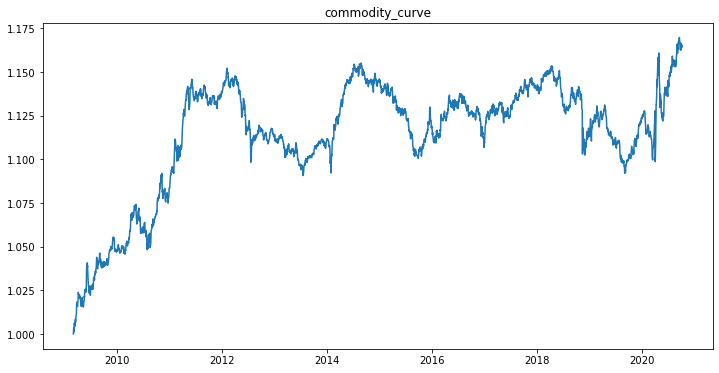

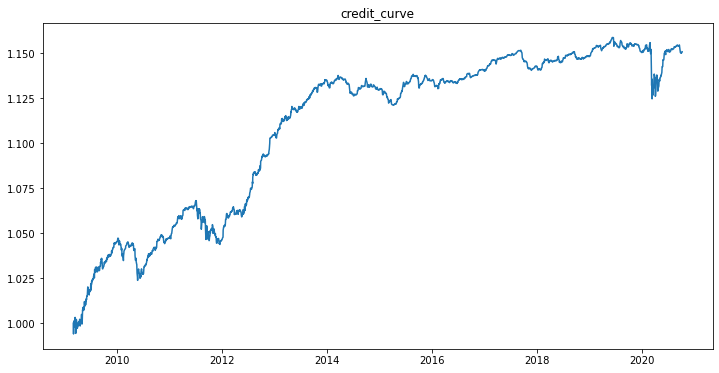

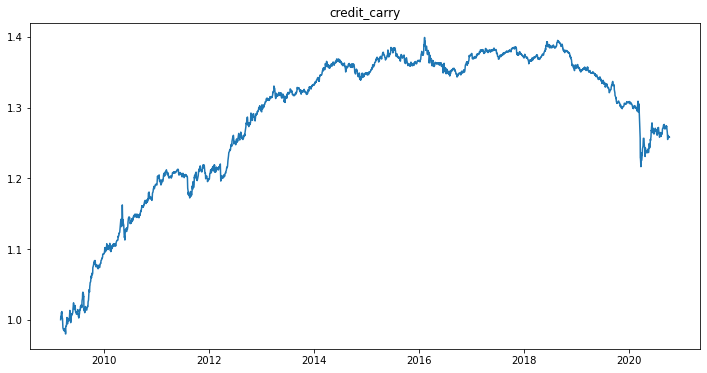

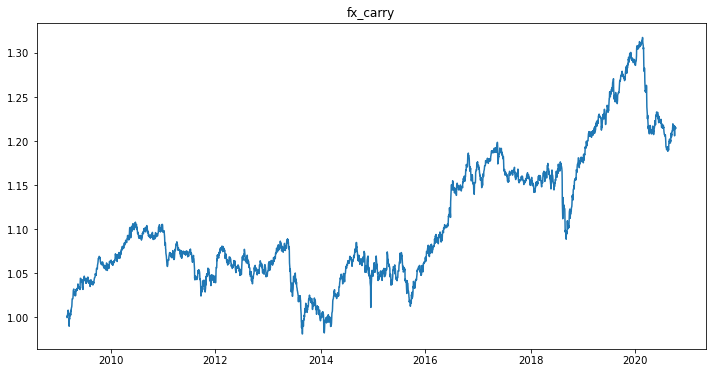

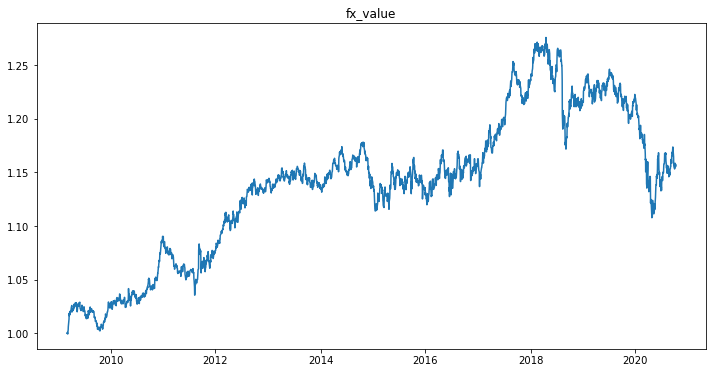

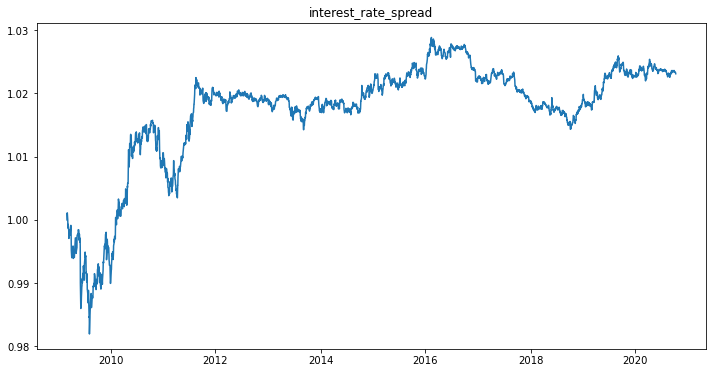

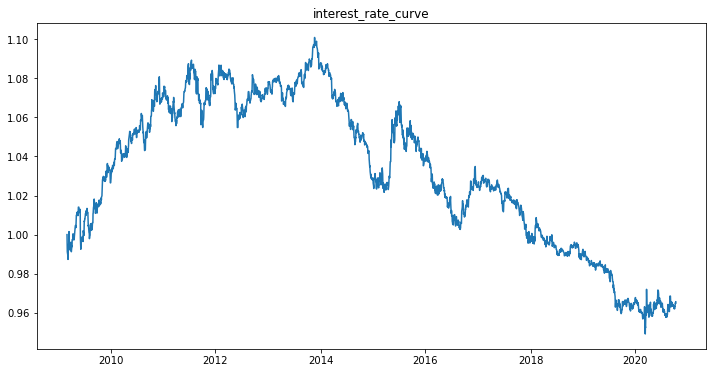

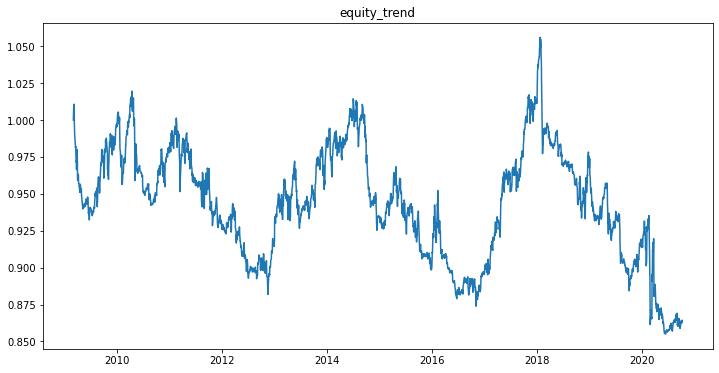

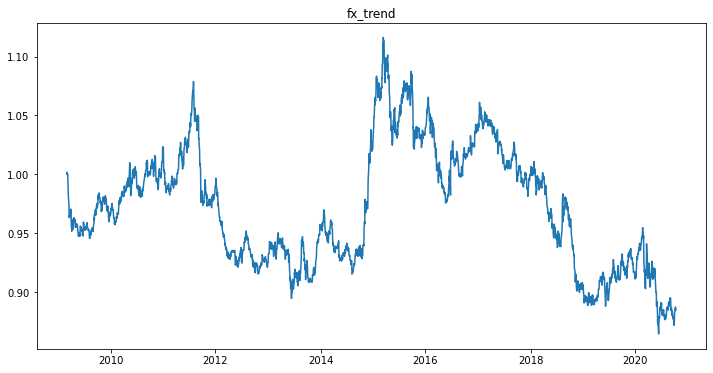

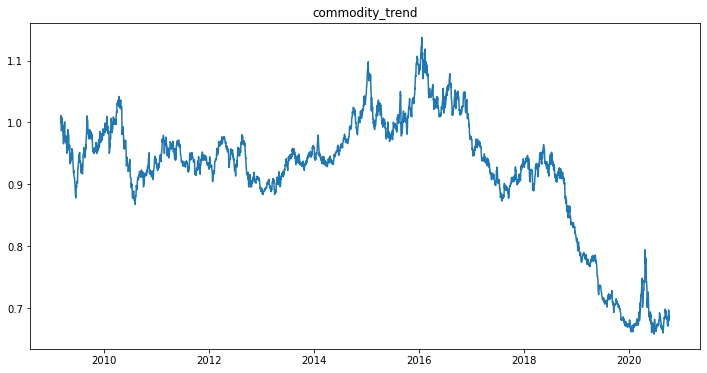

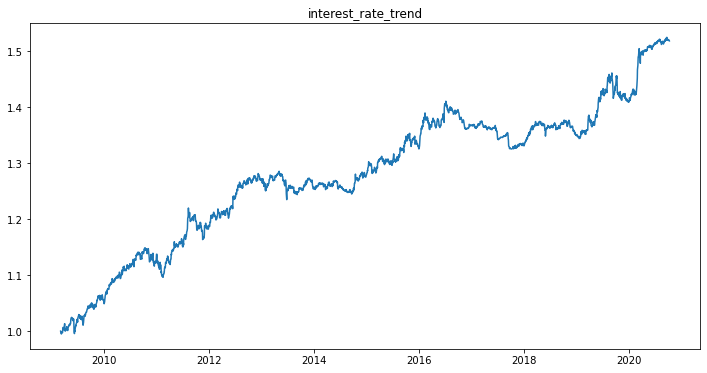

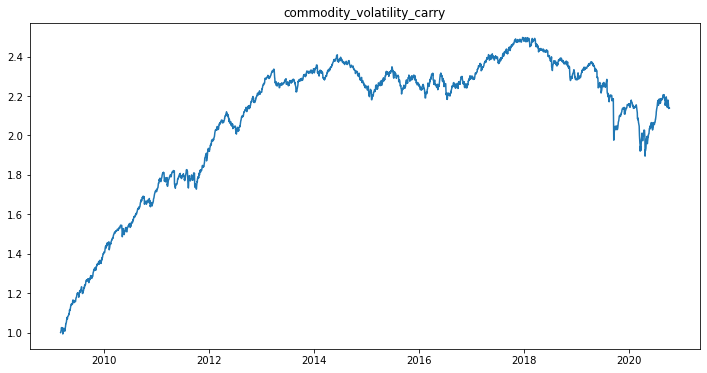

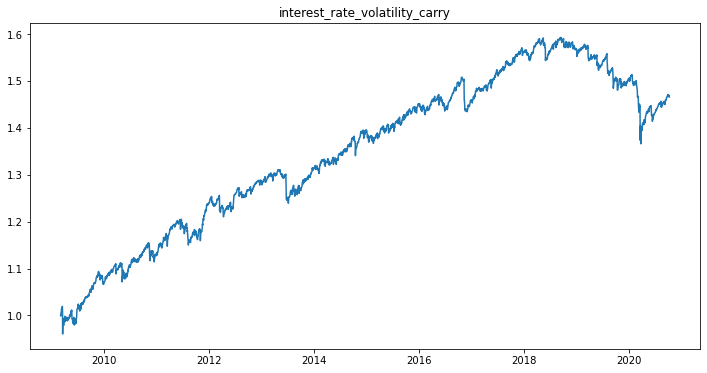

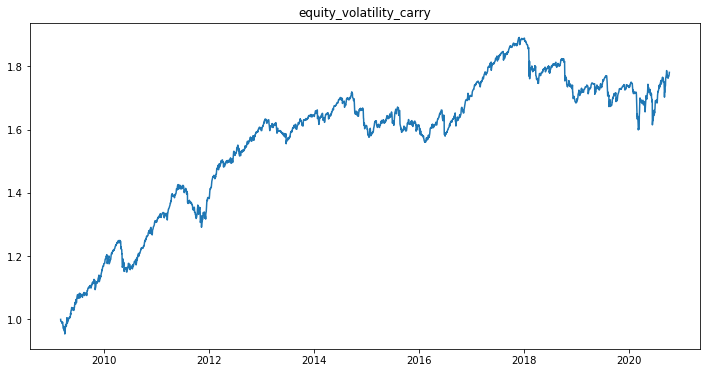

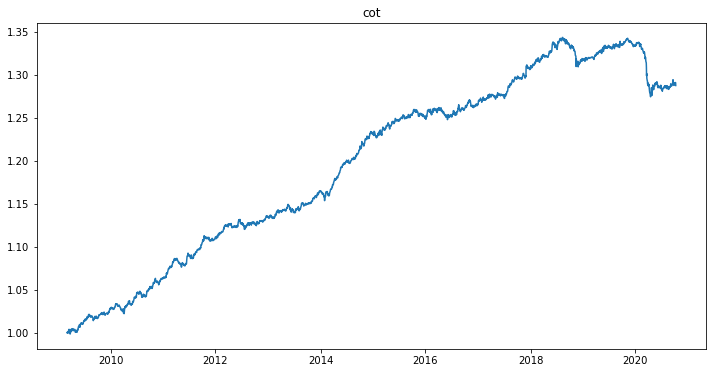

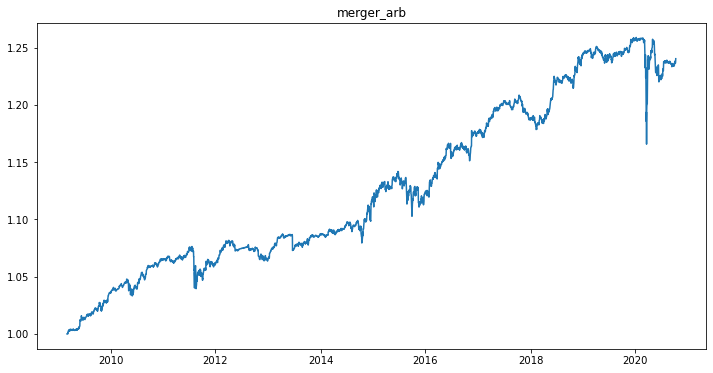

In [3]:
# print each strategy performance
import matplotlib.pyplot as plt 
for strategy in df_norm.columns[1:]:
    plt.figure(figsize=(12,6))
    plt.plot(df_norm['Date'], df_norm[strategy])
    plt.title(strategy)
    

In [4]:
list(df_return.columns[1:])

['equity_momentum',
 'equity_low_beta',
 'equity_quality',
 'commodity_carry',
 'commodity_curve',
 'credit_curve',
 'credit_carry',
 'fx_carry',
 'fx_value',
 'interest_rate_spread',
 'interest_rate_curve',
 'equity_trend',
 'fx_trend',
 'commodity_trend',
 'interest_rate_trend',
 'commodity_volatility_carry',
 'interest_rate_volatility_carry',
 'equity_volatility_carry',
 'cot',
 'merger_arb']

In [5]:
def get_stats(weights, df_return):
    weights = np.array(weights)
    ret = np.sum(df_return.mean() * weights) * 252 
    vol = np.sqrt(np.dot(weights.T, np.dot(df_return.cov() * 252, weights)))
    sharpe_ratio = ret/vol 
    return [ret, vol, sharpe_ratio]

def neg_sharpe(weights, df_return):
    return get_stats(weights, df_return)[2] * (-1)

def check_sum(weights):
    return np.sum(weights) - 1

In [39]:
def portfolio_optimisation(df_return=df_return, 
                           cutoff_date='2000-01-01', 
                           upper_bound=1,
                           drop_strategy=['equity_momentum']):
    
    df_return = df_return[df_return['Date']>cutoff_date]
    
    try:
        df_return = df_return.drop(drop_strategy, axis=1)
    except:
        pass 

    
    num_strategies = len(df_return.columns) - 1
    
    init_guess = np.array(np.random.random(num_strategies))
    init_guess /= np.sum(init_guess)
    
    cons = ({'type': 'eq', 'fun': check_sum})
    bounds = tuple([(0,upper_bound) for i in range(num_strategies)])
    opt_results = minimize(fun=neg_sharpe, 
                           x0=init_guess, 
                           args=(df_return),
                           method='SLSQP', 
                           bounds=bounds, 
                           constraints=cons)
    
    df_portfolio = df_return[df_return.columns[1:]] * opt_results.x
    df_portfolio_sum = pd.DataFrame()
    df_portfolio_sum['Date'] = df_return['Date']
    df_portfolio_sum['perf'] = (1+df_portfolio.sum(axis=1)).cumprod()
    plt.plot(df_portfolio_sum['Date'], df_portfolio_sum['perf'])
    
    return -opt_results.fun, df_portfolio_sum, opt_results.x

In [40]:
settings = [
            ('2009-01-01', 1, None), 
            ('2015-09-01', 1, None),
            ('2017-09-01', 1, None),
            ('2009-01-01', 0.1, None),
            ('2015-09-01', 0.1, None),
            ('2017-09-01', 0.1, None),
            ('2009-01-01', 1, 'equity_momentum'), 
            ('2015-09-01', 1, 'equity_momentum'),
            ('2017-09-01', 1, 'equity_momentum'),
            ('2009-01-01', 0.1, 'equity_momentum'),
            ('2015-09-01', 0.1, 'equity_momentum'),
            ('2017-09-01', 0.1, 'equity_momentum')
           ]

result = {} 

('2009-01-01', 1, None)
('2015-09-01', 1, None)
('2017-09-01', 1, None)
('2009-01-01', 0.1, None)
('2015-09-01', 0.1, None)
('2017-09-01', 0.1, None)
('2009-01-01', 1, 'equity_momentum')
('2015-09-01', 1, 'equity_momentum')
('2017-09-01', 1, 'equity_momentum')
('2009-01-01', 0.1, 'equity_momentum')
('2015-09-01', 0.1, 'equity_momentum')
('2017-09-01', 0.1, 'equity_momentum')
CPU times: user 1min 29s, sys: 636 ms, total: 1min 29s
Wall time: 46.3 s


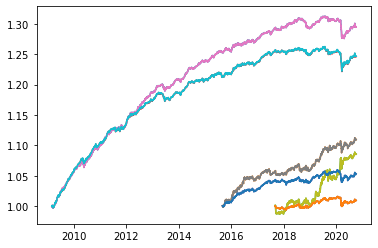

In [41]:
%%time
for config in settings:
    print(config)
    result[config] = portfolio_optimisation(df_return, 
                                            cutoff_date=config[0],
                                            upper_bound=config[1],
                                            drop_strategy=config[2])

In [62]:
for i, config in enumerate(settings): 
    print(i+1, config)
    print(result[config][0])
    result[config][1].to_csv(config[0]+'_'+ str(config[1])+'_'+str(config[2])+'.csv')
    print(result[config][2])

1 ('2009-01-01', 1, None)
2.376285872110638
[0.00000000e+00 4.98495248e-02 0.00000000e+00 7.34405425e-15
 3.20659482e-02 2.44741347e-01 7.13230447e-02 2.02243446e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.45406512e-16
 3.30041481e-15 3.72114297e-15 1.38406770e-01 3.17330920e-02
 5.76002850e-03 3.93670549e-02 3.38860626e-01 2.76682191e-02]
2 ('2015-09-01', 1, None)
1.3540201934283855
[0.00000000e+00 0.00000000e+00 0.00000000e+00 5.54968567e-15
 1.15320220e-01 0.00000000e+00 0.00000000e+00 1.55946215e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.61700621e-16
 2.20414443e-15 4.58958559e-15 3.35281626e-01 7.10519922e-16
 0.00000000e+00 6.78834986e-02 1.39109850e-01 1.86458590e-01]
3 ('2017-09-01', 1, None)
1.2336632687885691
[1.39160101e-15 8.86196099e-16 0.00000000e+00 1.59082359e-14
 1.05211038e-01 0.00000000e+00 0.00000000e+00 1.42405907e-01
 3.44016392e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.15835901e-17 1.06198319e-14 6.19410391e-01 2.94585116e-15
 1.8901658